# **Feed Forward Neural Network**
**Starting parameters**:

- Number of epochs: 100
- Learning rate: 0.0001
- Layers: [256, 128, 64]
- Dropout: 0.3


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Standard libraries
import numpy as np
import pandas as pd
import time
import os

# For preprocessing
import tensorflow as tf

# For modeling
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, roc_auc_score, f1_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Operational
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
import random

In [3]:
pkl_path = '/content/drive/My Drive/Final-Year-Project/Dataset/Final-Version-of-Bird-Classification-Project/feature-extraction/Annotated/Regular/AveragePooled/split_features_1s_all_1D.pkl'

# Load the pickle file
with open(pkl_path, 'rb') as file:
    data = pickle.load(file)

In [4]:
path = '/content/drive/My Drive/Final-Year-Project/Final-Version-of-Bird-Classification-Project/a. Imbalanced-Data/3. Training/Figures/FFNN/'

In [5]:
train_data = data['train'].copy()
val_data = data['val'].copy()

train_labels = train_data['label'].copy()
temp = train_data.copy()
del temp['label']
tr_features = temp

val_labels = val_data['label'].copy()
temp = val_data.copy()
del temp['label']
v_features = temp

## **Shuffling Data**

In [6]:
def shuffle_data(input_label, input_features):
  input_len = len(input_label)
  np.random.seed(1826)
  input_indices = np.random.permutation(input_len)
  input_features = {key: np.array([input_features[key][i] for i in input_indices]) for key in input_features} # dictionary comprehension
  input_label = np.array([input_label[i] for i in input_indices])

  return input_label, input_features

In [7]:
train_y, train_features = shuffle_data(train_labels, tr_features)

In [8]:
val_y, val_features = shuffle_data(val_labels, v_features)

## **Feed Forward Model**

In [9]:
def build_model(input_features,
                hidden_layers=[256, 128, 64],
                learning_rate=0.0001,
                output_units=20,
                dropout_rate=0.3):

  tf.keras.backend.clear_session()

  # set input layer
  input = tf.keras.Input(shape=(input_features,), name='Input')

  # set hidden layers
  hidden_output = input

  for i, hidden_dim in enumerate(hidden_layers):
    hidden_output = tf.keras.layers.Dense(units=hidden_dim,
                                          activation='relu',
                                          name=f'hidden{i}')(hidden_output)
    hidden_output = tf.keras.layers.Dropout(rate=dropout_rate, name=f'dropout{i}')(hidden_output)

  # set output layer
  output = tf.keras.layers.Dense(units=output_units,
                                 activation='softmax',
                                 name='Output')(hidden_output)
  # create model
  model = tf.keras.models.Model(inputs=input, outputs=[output])

  # compile model
  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                metrics=['accuracy'])

  return model

In [10]:
def visualize(model_history, name):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    # Visualize the loss
    axes[0].plot(model_history.history['loss'], color='red', label='Training Loss')
    axes[0].plot(model_history.history['val_loss'], color='blue', label='Validation Loss')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Loss Progression', fontsize=14)
    axes[0].grid(True)
    axes[0].legend()

    # Visualize the accuracy
    axes[1].plot(model_history.history['accuracy'], color='green', label='Training Accuracy')
    axes[1].plot(model_history.history['val_accuracy'], color='orange', label='Validation Accuracy')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy', fontsize=12)
    axes[1].set_title('Accuracy Progression', fontsize=14)
    axes[1].grid(True)
    axes[1].legend()

    plt.savefig(f'{path+name}_1s_model_training_history_1D_annotated.pdf')

    # Fine-tune layout and display the plots
    plt.tight_layout()
    plt.show()

In [11]:
def evaluate_model(val_y, val_yhat, val_yhat_result, num_classes=20):

    print('Validation classification Report \n')
    print(classification_report(val_y, val_yhat_result))

    # Calculate AUC for multiclass classification using 'ovr' and 'weighted' average
    auc_score = roc_auc_score(val_y, val_yhat, multi_class='ovr', average='weighted')
    print(f'AUC Score: {auc_score}')

    # Calculate F1-score with 'weighted' average for imbalanced dataset
    f1 = f1_score(val_y, val_yhat_result, average='weighted')
    print(f'F1 Score (Weighted): {f1}')

    val_score = {'f1': f1, 'auc': auc_score}

    return val_score

In [12]:
train_results = {}
val_results = {}

val_scores = {}

### With All Features

In [13]:
training_features = np.concatenate((train_features['mfcc'], train_features['chroma'], train_features['cqt'], train_features['melspectrogram']), axis=1)
training_features.shape

(12565, 244)

In [14]:
validation_features = np.concatenate((val_features['mfcc'], val_features['chroma'], val_features['cqt'], val_features['melspectrogram']), axis=1)
validation_features.shape

(3318, 244)

In [15]:
scaler = StandardScaler()
training_features = scaler.fit_transform(training_features)
validation_features = scaler.transform(validation_features)

model = build_model(input_features=training_features.shape[1])

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=1,
)

Epoch 1/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.2165 - loss: 2.6478 - val_accuracy: 0.4268 - val_loss: 1.8278
Epoch 2/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4320 - loss: 1.8150 - val_accuracy: 0.5687 - val_loss: 1.4353
Epoch 3/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5331 - loss: 1.4834 - val_accuracy: 0.6007 - val_loss: 1.2545
Epoch 4/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6115 - loss: 1.2532 - val_accuracy: 0.6166 - val_loss: 1.1587
Epoch 5/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6586 - loss: 1.0775 - val_accuracy: 0.6417 - val_loss: 1.1016
Epoch 6/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6788 - loss: 1.0121 - val_accuracy: 0.6519 - val_loss: 1.0547
Epoch 7/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7163 - loss: 0.9120 - val_accuracy: 0.6516 - val_loss: 1.0484
Epoch 8/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7449 - loss: 0.8169 - val_accu

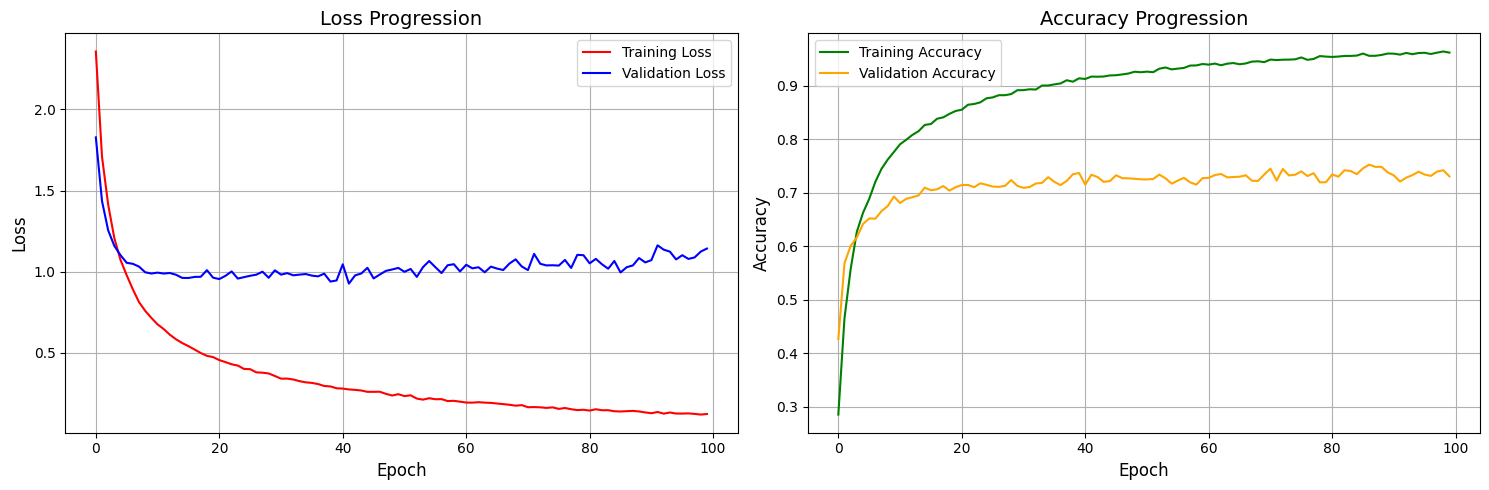

In [16]:
visualize(history, 'all_features')

In [17]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['all_features'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['all_features'] = model.evaluate(validation_features, val_y)[-1]

393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9901 - loss: 0.0331
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7307 - loss: 1.1581


In [18]:
val_scores['all_features'] = evaluate_model(val_y=val_y, val_yhat=val_yhat, val_yhat_result=val_yhat_result)

Validation classification Report 

              precision    recall  f1-score   support

           0       0.76      0.77      0.76       455
           1       0.54      0.63      0.58       492
           2       0.84      0.73      0.78       889
           3       0.77      1.00      0.87       150
           4       0.53      0.12      0.20        67
           5       0.81      0.70      0.75        43
           6       0.33      0.33      0.33        24
           7       1.00      1.00      1.00        44
           8       0.55      0.56      0.55        50
           9       0.93      0.99      0.96       169
          10       0.76      0.49      0.60        53
          11       0.45      0.55      0.49        66
          12       0.81      0.73      0.77        59
          13       0.66      0.77      0.71        57
          14       0.63      0.84      0.72        38
          15       0.67      0.63      0.65       311
          16       0.98      0.98      0.98   

### Mel Spectrogram and Chroma

In [19]:
training_features = np.concatenate((train_features['melspectrogram'], train_features['chroma']), axis=1)
training_features.shape

(12565, 140)

In [20]:
validation_features = np.concatenate((val_features['melspectrogram'], val_features['chroma']), axis=1)
validation_features.shape

(3318, 140)

In [21]:
scaler = StandardScaler()
training_features = scaler.fit_transform(training_features)
validation_features = scaler.transform(validation_features)

model = build_model(input_features=training_features.shape[1])

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=1,
)

Epoch 1/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2055 - loss: 2.6694 - val_accuracy: 0.4665 - val_loss: 1.8285
Epoch 2/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4088 - loss: 1.8901 - val_accuracy: 0.5259 - val_loss: 1.4948
Epoch 3/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4905 - loss: 1.5733 - val_accuracy: 0.5651 - val_loss: 1.3425
Epoch 4/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5657 - loss: 1.3577 - val_accuracy: 0.5799 - val_loss: 1.2830
Epoch 5/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6111 - loss: 1.2225 - val_accuracy: 0.5928 - val_loss: 1.2400
Epoch 6/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6453 - loss: 1.1214 - val_accuracy: 0.5934 - val_loss: 1.2213
Epoch 7/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6671 - loss: 1.0297 - val_accuracy: 0.6061 - val_loss: 1.2078
Epoch 8/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6963 - loss: 0.9568 - val_accu

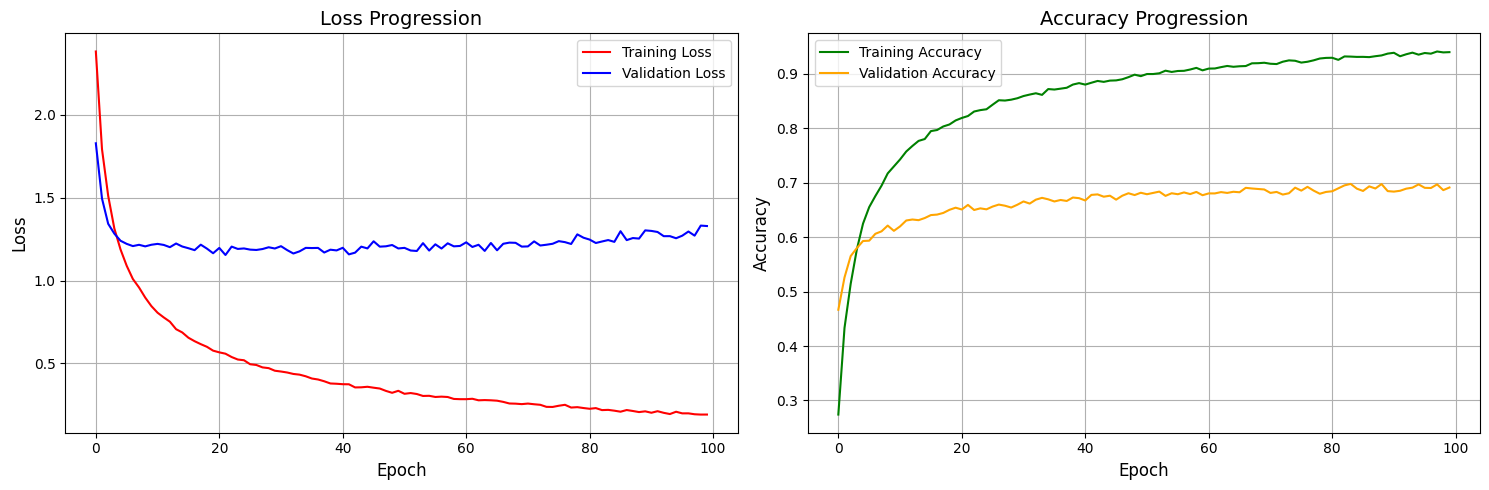

In [22]:
visualize(history, 'melspectrogram_chroma')

In [23]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['melspectrogram_chroma'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['melspectrogram_chroma'] = model.evaluate(validation_features, val_y)[-1]

393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
393/393 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9802 - loss: 0.0664
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6920 - loss: 1.3202


In [24]:
val_scores['melspectrogram_chroma'] = evaluate_model(val_y=val_y, val_yhat=val_yhat, val_yhat_result=val_yhat_result)

Validation classification Report 

              precision    recall  f1-score   support

           0       0.82      0.82      0.82       455
           1       0.45      0.47      0.46       492
           2       0.79      0.71      0.75       889
           3       0.80      0.96      0.87       150
           4       0.76      0.28      0.41        67
           5       0.50      0.44      0.47        43
           6       0.06      0.08      0.07        24
           7       0.98      0.98      0.98        44
           8       0.55      0.62      0.58        50
           9       0.91      0.98      0.95       169
          10       0.85      0.64      0.73        53
          11       0.47      0.52      0.49        66
          12       0.44      0.32      0.37        59
          13       0.49      0.77      0.60        57
          14       0.54      0.68      0.60        38
          15       0.61      0.60      0.61       311
          16       0.88      0.96      0.92   

### With Mel Spectrogram, MFCCs and Chroma

In [25]:
training_features = np.concatenate((train_features['melspectrogram'], train_features['chroma'], train_features['mfcc']), axis=1)
training_features.shape

(12565, 160)

In [26]:
validation_features = np.concatenate((val_features['melspectrogram'], val_features['chroma'], val_features['mfcc']), axis=1)
validation_features.shape

(3318, 160)

In [27]:
scaler = StandardScaler()
training_features = scaler.fit_transform(training_features)
validation_features = scaler.transform(validation_features)

model = build_model(input_features=training_features.shape[1])

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=1,
)

Epoch 1/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1995 - loss: 2.6839 - val_accuracy: 0.4397 - val_loss: 1.8204
Epoch 2/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4191 - loss: 1.8566 - val_accuracy: 0.5561 - val_loss: 1.4728
Epoch 3/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5262 - loss: 1.4943 - val_accuracy: 0.5793 - val_loss: 1.3159
Epoch 4/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6120 - loss: 1.2561 - val_accuracy: 0.5853 - val_loss: 1.2332
Epoch 5/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6412 - loss: 1.1300 - val_accuracy: 0.6001 - val_loss: 1.1969
Epoch 6/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6776 - loss: 1.0203 - val_accuracy: 0.6127 - val_loss: 1.1612
Epoch 7/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7080 - loss: 0.9285 - val_accuracy: 0.6160 - val_loss: 1.1539
Epoch 8/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7245 - loss: 0.8997 - val_accu

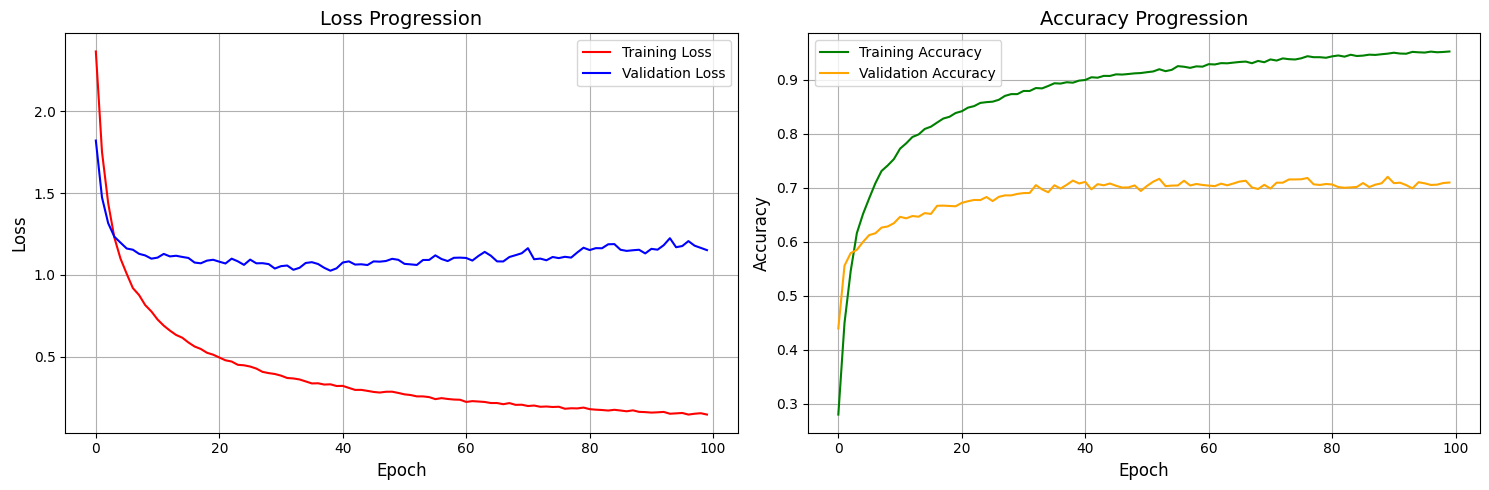

In [28]:
visualize(history, 'melspectrogram_chroma_mfcc')

In [29]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['melspectrogram_chroma_mfcc'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['melspectrogram_chroma_mfcc'] = model.evaluate(validation_features, val_y)[-1]

393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
393/393 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9887 - loss: 0.0406
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7175 - loss: 1.1395


In [30]:
val_scores['melspectrogram_chroma_mfcc'] = evaluate_model(val_y=val_y, val_yhat=val_yhat, val_yhat_result=val_yhat_result)

Validation classification Report 

              precision    recall  f1-score   support

           0       0.79      0.83      0.81       455
           1       0.54      0.51      0.52       492
           2       0.80      0.72      0.76       889
           3       0.86      1.00      0.93       150
           4       0.95      0.30      0.45        67
           5       0.63      0.44      0.52        43
           6       0.12      0.33      0.18        24
           7       0.98      1.00      0.99        44
           8       0.59      0.58      0.59        50
           9       0.89      0.99      0.94       169
          10       0.85      0.55      0.67        53
          11       0.38      0.38      0.38        66
          12       0.52      0.39      0.45        59
          13       0.55      0.68      0.61        57
          14       0.47      0.84      0.60        38
          15       0.62      0.69      0.65       311
          16       0.98      0.98      0.98   

### With Mel Spectrogram and MFCCs

In [31]:
training_features = np.concatenate((train_features['melspectrogram'], train_features['mfcc']), axis=1)
training_features.shape

(12565, 148)

In [32]:
validation_features = np.concatenate((val_features['melspectrogram'], val_features['mfcc']), axis=1)
validation_features.shape

(3318, 148)

In [33]:
scaler = StandardScaler()
training_features = scaler.fit_transform(training_features)
validation_features = scaler.transform(validation_features)

model = build_model(input_features=training_features.shape[1])

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=1,
)

Epoch 1/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1800 - loss: 2.7058 - val_accuracy: 0.4997 - val_loss: 1.8147
Epoch 2/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4029 - loss: 1.9191 - val_accuracy: 0.5735 - val_loss: 1.4769
Epoch 3/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5009 - loss: 1.5961 - val_accuracy: 0.5913 - val_loss: 1.3303
Epoch 4/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5611 - loss: 1.3983 - val_accuracy: 0.5943 - val_loss: 1.2563
Epoch 5/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6100 - loss: 1.2542 - val_accuracy: 0.6100 - val_loss: 1.1888
Epoch 6/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6402 - loss: 1.1347 - val_accuracy: 0.6037 - val_loss: 1.1815
Epoch 7/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6626 - loss: 1.0690 - val_accuracy: 0.6013 - val_loss: 1.1864
Epoch 8/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6894 - loss: 0.9771 - val_accu

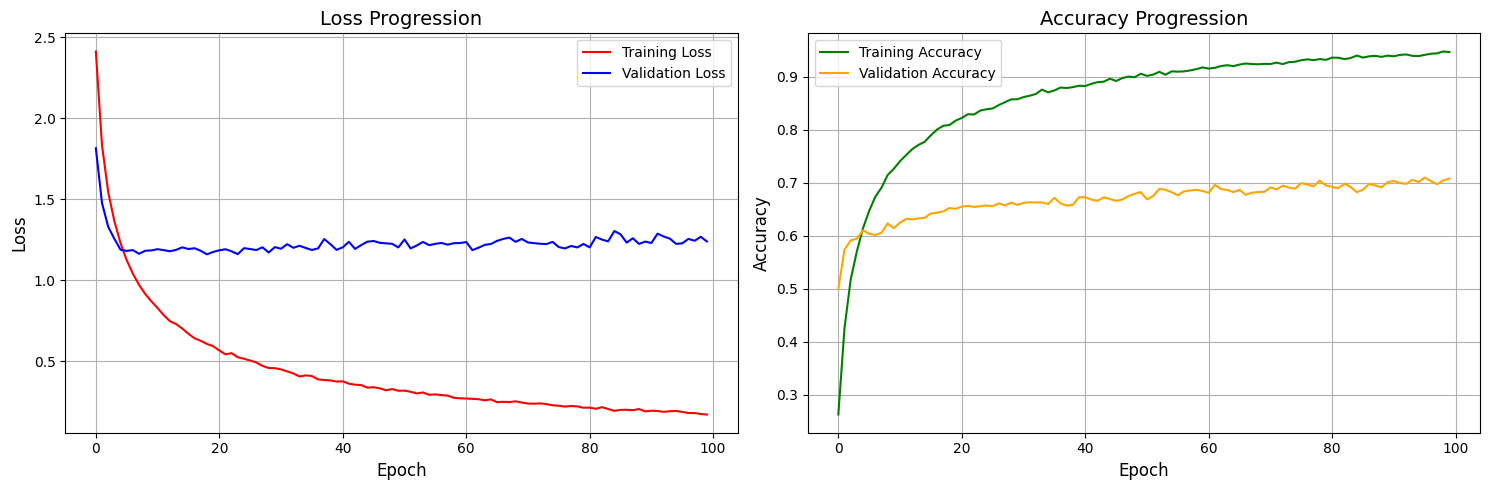

In [34]:
visualize(history, 'mfcc_melspectrogram')

In [35]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['mfcc_melspectrogram'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['mfcc_melspectrogram'] = model.evaluate(validation_features, val_y)[-1]

393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
393/393 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9845 - loss: 0.0546
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7149 - loss: 1.2258


In [36]:
val_scores['mfcc_melspectrogram'] = evaluate_model(val_y=val_y, val_yhat=val_yhat, val_yhat_result=val_yhat_result)

Validation classification Report 

              precision    recall  f1-score   support

           0       0.76      0.82      0.79       455
           1       0.53      0.51      0.52       492
           2       0.80      0.73      0.76       889
           3       0.87      1.00      0.93       150
           4       0.80      0.06      0.11        67
           5       0.59      0.37      0.46        43
           6       0.25      0.29      0.27        24
           7       0.98      0.98      0.98        44
           8       0.47      0.80      0.59        50
           9       0.90      0.95      0.92       169
          10       0.69      0.34      0.46        53
          11       0.33      0.21      0.26        66
          12       0.40      0.64      0.49        59
          13       0.66      0.70      0.68        57
          14       0.60      0.87      0.71        38
          15       0.68      0.72      0.70       311
          16       0.96      0.96      0.96   

### With Mel Spectrogram

In [37]:
training_features = train_features['melspectrogram']
training_features.shape

(12565, 128)

In [38]:
validation_features = val_features['melspectrogram']
validation_features.shape

(3318, 128)

In [39]:
scaler = StandardScaler()
training_features = scaler.fit_transform(training_features)
validation_features = scaler.transform(validation_features)

model = build_model(input_features=training_features.shape[1])

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=1,
)

Epoch 1/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1486 - loss: 2.8067 - val_accuracy: 0.4144 - val_loss: 1.9202
Epoch 2/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3869 - loss: 1.9676 - val_accuracy: 0.4904 - val_loss: 1.5825
Epoch 3/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4719 - loss: 1.6553 - val_accuracy: 0.5304 - val_loss: 1.4233
Epoch 4/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5317 - loss: 1.4836 - val_accuracy: 0.5518 - val_loss: 1.3530
Epoch 5/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5636 - loss: 1.3714 - val_accuracy: 0.5558 - val_loss: 1.3150
Epoch 6/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6064 - loss: 1.2310 - val_accuracy: 0.5660 - val_loss: 1.2821
Epoch 7/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6207 - loss: 1.1483 - val_accuracy: 0.5732 - val_loss: 1.2647
Epoch 8/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6476 - loss: 1.0913 - val_accu

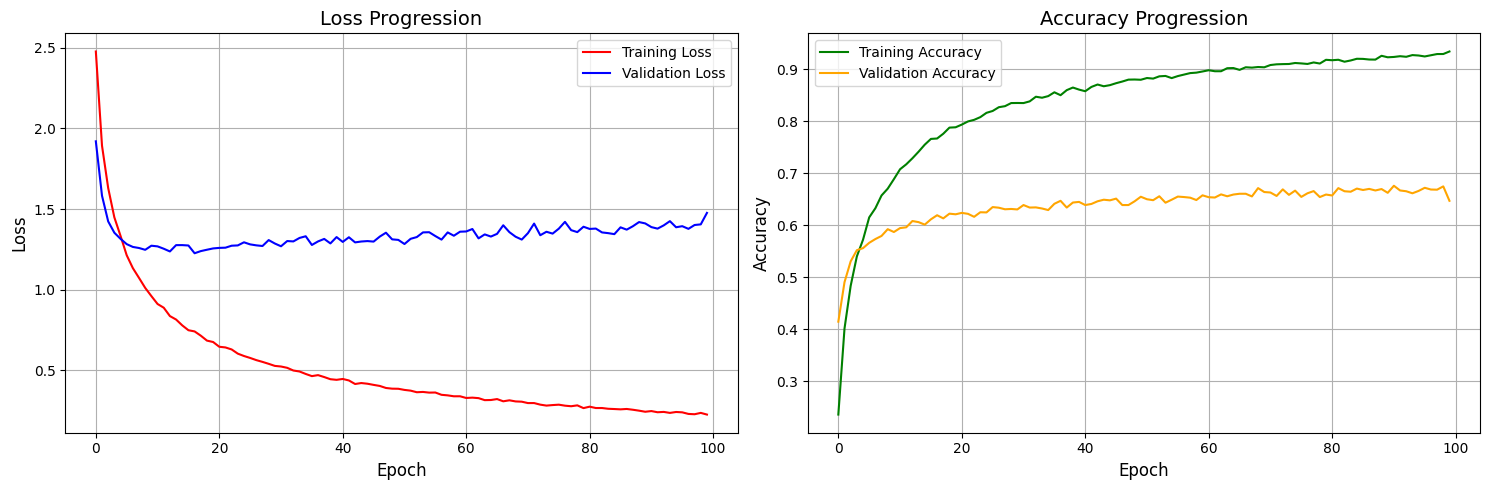

In [40]:
visualize(history, 'melspectrogram')

In [41]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['melspectrogram'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['melspectrogram'] = model.evaluate(validation_features, val_y)[-1]

393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
393/393 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9734 - loss: 0.0935
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6501 - loss: 1.4537


In [42]:
val_scores['melspectrogram'] = evaluate_model(val_y=val_y, val_yhat=val_yhat, val_yhat_result=val_yhat_result)

Validation classification Report 

              precision    recall  f1-score   support

           0       0.80      0.70      0.75       455
           1       0.43      0.52      0.47       492
           2       0.75      0.64      0.69       889
           3       0.87      1.00      0.93       150
           4       0.96      0.36      0.52        67
           5       0.26      0.23      0.24        43
           6       0.10      0.12      0.11        24
           7       1.00      0.93      0.96        44
           8       0.50      0.60      0.55        50
           9       0.92      0.91      0.91       169
          10       0.52      0.32      0.40        53
          11       0.28      0.26      0.27        66
          12       0.39      0.71      0.51        59
          13       0.38      0.67      0.48        57
          14       0.58      0.47      0.52        38
          15       0.54      0.56      0.55       311
          16       0.95      0.96      0.95   

## Review all the results

In [43]:
train_results_df = pd.DataFrame(list(train_results.items()), columns=['Features', 'Train_Accuracy']).round(3)
val_results_df = pd.DataFrame(list(val_results.items()), columns=['Features', 'Val_Accuracy']).round(3)

result_df = train_results_df.merge(val_results_df, on='Features')
result_df = result_df.sort_values('Features')
result_df

,Features,Train_Accuracy,Val_Accuracy
0,all_features,0.991,0.731
4,melspectrogram,0.974,0.647
1,melspectrogram_chroma,0.979,0.691
2,melspectrogram_chroma_mfcc,0.989,0.710
3,mfcc_melspectrogram,0.985,0.708


In [44]:
val_scores_df = pd.DataFrame([(key, value['f1'], value['auc']) for key, value in val_scores.items()],
                             columns=['Features', 'F1_Score', 'AUC_Score']).round(3)

val_scores_df = val_scores_df.sort_values('Features')
print(val_scores_df)

                     Features  F1_Score  AUC_Score
0                all_features     0.728      0.954
4              melspectrogram     0.651      0.926
1       melspectrogram_chroma     0.690      0.937
2  melspectrogram_chroma_mfcc     0.710      0.948
3         mfcc_melspectrogram     0.700      0.942
